# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from keras.optimizers import Adam

# Import Data


In [ ]:
data = pd.read_csv("./MNIST.csv").astype('float32')
data.head()

In [5]:
width, height, channel = 28, 28, 1

In [ ]:
X = data.iloc[:,1:].values
X = X.reshape((372450, width, height))
np.random.shuffle(X)
X.shape

In [5]:
X = (X - 127.5) / 127.5

# Show some sample form dataset

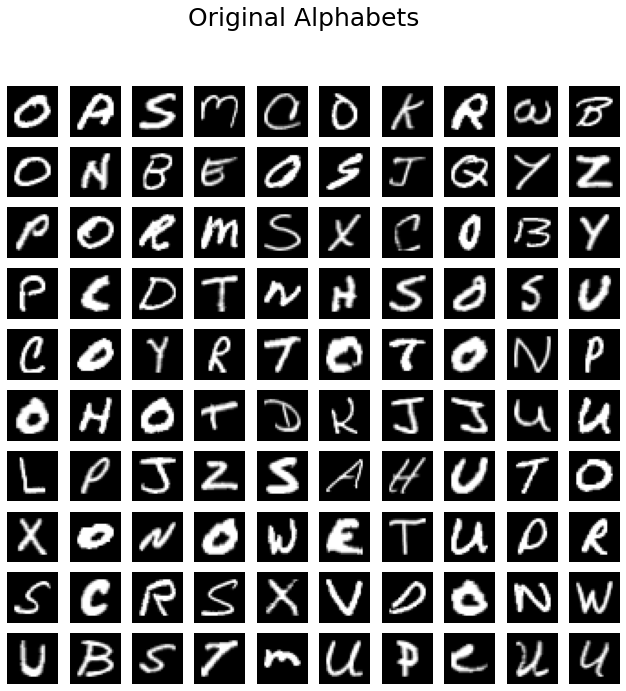

In [6]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Alphabets")

# Hyper-parameter tuning

In [7]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

# Generator Network

In [8]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [9]:
generator = buildGenerator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)        

# Descriminator Network

In [10]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [11]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)              

# Adversarial Network

In [12]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [13]:
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         6595073   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1026305   
Total params: 7,621,378
Trainable params: 6,580,353
Non-trainable params: 1,041,025
_________________________________________________________________


# Distribution of Noise Sample

In [14]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

# Show Generated Letter

In [15]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [16]:
epochs = 81
batch_size = 128
steps_per_epoch = len(X)//batch_size

In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)